In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from colorama import Fore, Style
from abc import ABC, abstractmethod
from typing import Callable, List, Optional, Dict, Tuple
from dataclasses import dataclass, field
import random

# Signal Generator

In [23]:
class Strategy(ABC):
    @abstractmethod
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """
        data: OHLCV (and extra) up to t‑1
        returns: Series indexed like data of +1 (long), -1 (short), 0 (flat)
        """

In [25]:
class SimpleMAMomentum(Strategy):
    """Long when price > SMA, Short when price < SMA"""
    def __init__(self, window: int = 24):
        self.window = window

    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        close = data['close']
        sma   = close.rolling(self.window).mean()

        signal = pd.Series(0, index=data.index)
        valid  = sma.notna()
        signal[valid & (close > sma)] = 1
        signal[valid & (close < sma)] = -1
        return signal

    def generate_positions(
        self,
        data: pd.DataFrame,
        latency_bars: int = 0
    ) -> pd.Series:
        """
        Returns a positions series (–1,0,1) ready for Backtester:
          - shifts signals forward by (1 + latency_bars)
          - fills any NaNs with 0 and casts to int
        """
        sig = self.generate_signals(data)
        pos = sig.shift(1 + latency_bars).fillna(0).astype(int)
        return pos


# Backtesting Framework

In [ ]:
@dataclass
class BacktestConfig:
    trading_fee = 0.0006 # in percentage

In [10]:
from typing import Union, Optional, Dict
import pandas as pd
import matplotlib.pyplot as plt

class Backtester:
    def __init__(
        self,
        data: Union[pd.DataFrame, pd.Series],
        positions: Optional[pd.Series] = None,
        trade_fee: float = 0.0005
    ):
        # Normalize input:
        if isinstance(data, pd.Series):
            # Single series of close prices
            self.data = pd.DataFrame({'close': data})
            if positions is None:
                raise ValueError("Positions series must be provided when passing a Series of close prices.")
            self.data['positions'] = positions
        else:
            # Full DataFrame
            self.data = data.copy()
            if positions is not None:
                self.data['positions'] = positions
            elif 'positions' not in self.data:
                raise ValueError("Positions must be in the DataFrame or passed explicitly.")

        self.trade_fee = trade_fee

    def run(self) -> pd.DataFrame:
        df = self.data
        # 1) Price change
        df['price_change'] = df['close'].pct_change().fillna(0)
        # 2) Previous position and trades
        df['prev_pos'] = df['positions'].shift(1).fillna(0)
        df['trades'] = (df['positions'] - df['prev_pos']).abs()
        # 3) Raw PnL
        df['pnl_raw'] = df['prev_pos'] * df['price_change']
        # 4) Trade cost
        df['trade_cost'] = df['trades'] * self.trade_fee
        # 5) Net PnL
        df['pnl'] = df['pnl_raw'] - df['trade_cost']
        # 6) Equity curve
        df['equity'] = df['pnl'].cumsum()
        # 7) Rolling max drawdown
        rolling_max = df['equity'].shift(1).expanding().max()
        df['max_dd'] = df['equity'] - rolling_max
        df['max_dd'].iloc[0] = 0
        # 8) Metrics
        sharpe = df['pnl'].mean() / df['pnl'].std() if df['pnl'].std() > 0 else 0.0
        max_dd_value = df['max_dd'].min()
        trade_freq_pct = df['trades'].sum() / len(df) * 100
        print(f"Sharpe Ratio        : {sharpe:.4f}")
        print(f"Max Drawdown (PnL)  : {max_dd_value:.4f}")
        print(f"Trade Frequency (%) : {trade_freq_pct:.2f}")

        # Plots
        self._plot(
            left=df['close'],
            rights={'Equity': df['equity']},
            title='Close Price and Equity Curve'
        )
        self._plot(
            left=df['close'],
            rights={'Max Drawdown': df['max_dd']},
            title='Close Price vs Rolling Max Drawdown'
        )
        self._plot(
            left=df['close'],
            rights={'Equity': df['equity'], 'Max Drawdown': df['max_dd']},
            title='Close vs Equity & Max Drawdown'
        )

        return df[['close', 'positions', 'trades', 'pnl', 'equity', 'max_dd']]

    def _plot(
        self,
        left: pd.Series,
        rights: Dict[str, pd.Series],
        title: str,
        left_label: str = 'Close Price',
        right_label: Optional[str] = None,
        legend_loc: str = 'upper left'
    ):
        fig, ax_left = plt.subplots(figsize=(12, 6))
        ax_right = ax_left.twinx()

        # Plot left series
        ax_left.plot(left.index, left.values, label=left_label, color='tab:blue', linewidth=1.5)
        ax_left.set_ylabel(left_label, color='tab:blue')
        ax_left.tick_params(axis='y', labelcolor='tab:blue')

        # Plot right series
        colors = ['tab:green', 'tab:red', 'tab:purple']
        for (label, series), color in zip(rights.items(), colors):
            ax_right.plot(series.index, series.values, label=label, color=color, linewidth=1.5)
        ax_right.set_ylabel(right_label or ' / '.join(rights.keys()), color='tab:gray')
        ax_right.tick_params(axis='y', labelcolor='tab:gray')

        ax_left.set_title(title)
        ax_left.set_xlabel('Date')

        # Legends
        lines_left, labels_left = ax_left.get_legend_handles_labels()
        lines_right, labels_right = ax_right.get_legend_handles_labels()
        ax_left.legend(lines_left + lines_right, labels_left + labels_right, loc=legend_loc)

        plt.tight_layout()
        plt.show()


# Code Running

In [14]:
df = pd.read_csv("ohlcv.csv", dtype={"start_time": int})

# Convert 'datetime' column to proper datetime format
df["datetime"] = pd.to_datetime(df["datetime"])

# Drop 'start_time' column if it exists
df.drop(columns=["start_time"], inplace=True, errors="ignore")

# Set 'datetime' as the index and sort it
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)

df

,close,high,low,open,volume
datetime,,,,,
2024-01-01 00:00:00,42475.23,42554.57,42261.02,42283.58,1271.68108
2024-01-01 01:00:00,42613.56,42775.00,42431.65,42475.23,1196.37856
2024-01-01 02:00:00,42581.10,42638.41,42500.00,42613.57,685.21980
2024-01-01 03:00:00,42330.49,42586.64,42230.08,42581.09,794.80391
2024-01-01 04:00:00,42399.99,42399.99,42209.46,42330.50,715.41760
...,...,...,...,...,...
2024-12-31 19:00:00,94166.88,94290.91,93712.45,93875.69,462.79342
2024-12-31 20:00:00,93564.04,94222.50,93450.17,94166.88,733.04147
2024-12-31 21:00:00,93899.68,93964.15,93504.67,93564.01,337.52715


Sharpe Ratio        : -0.0846
Max Drawdown (PnL)  : -3.4574
Trade Frequency (%) : 89.22


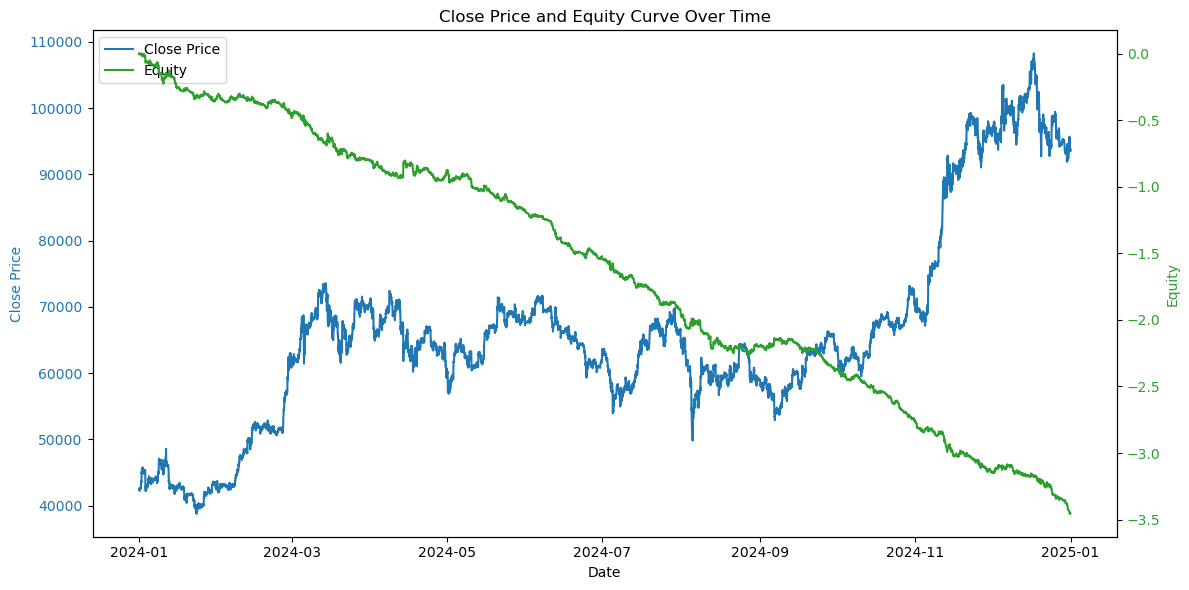

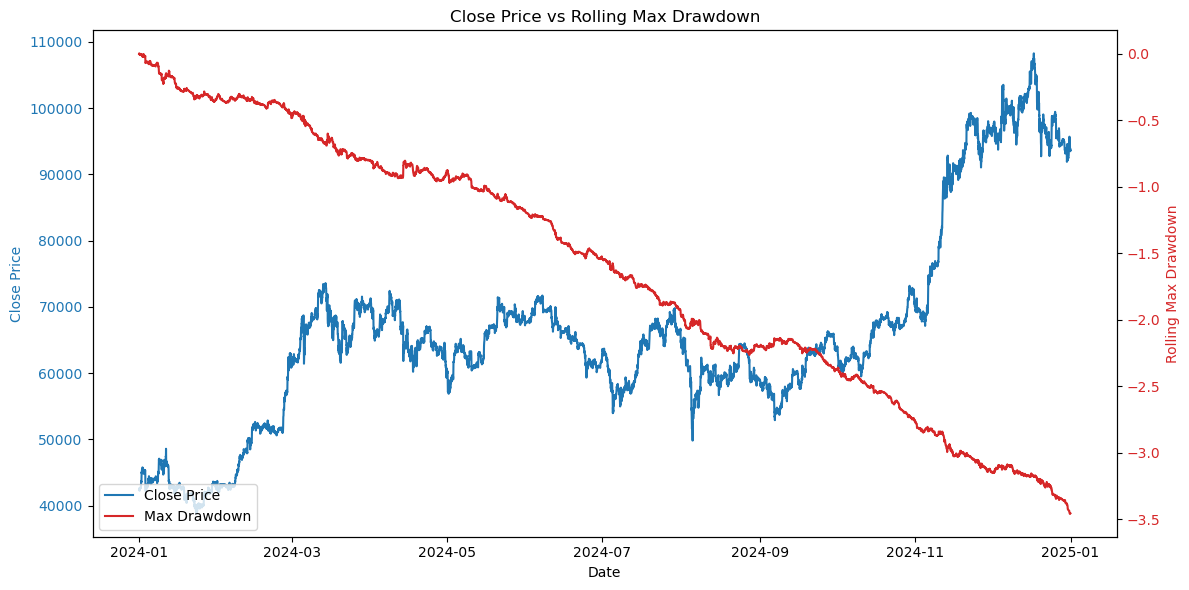

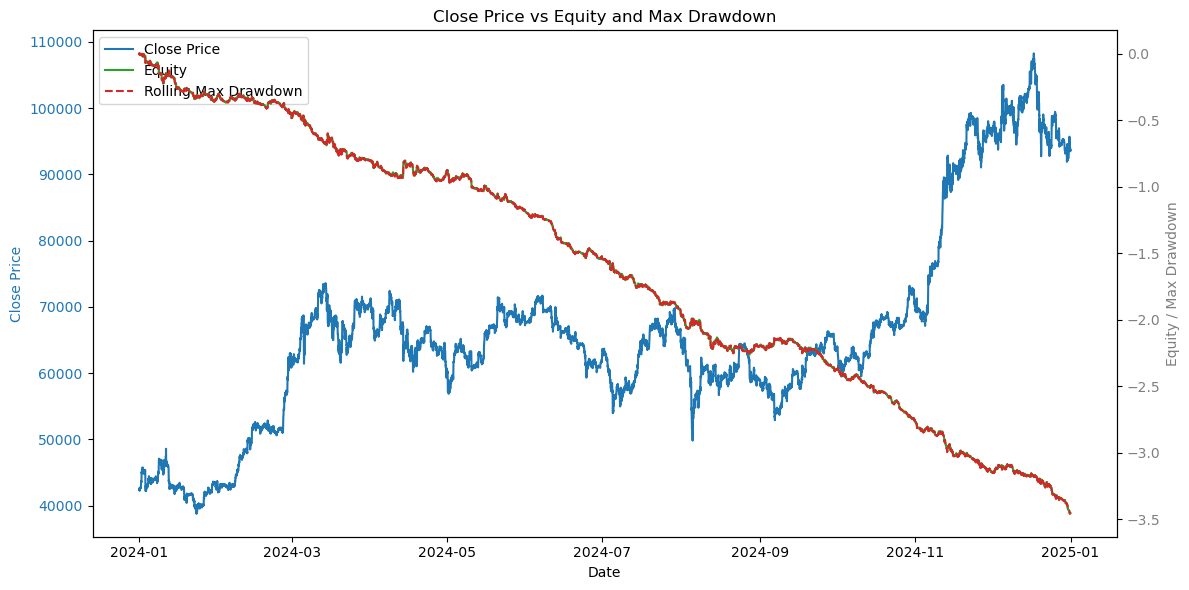

In [17]:
np.random.seed(42)

bt = Backtester(df, pd.Series(positions, index=df.index), trade_fee=0.0005)
results = bt.run()

In [ ]:
strat = SimpleMAMomentum(window=24)

# 2) Build positions (using your DataFrame `df` and config.latency_bars)
positions = strat.generate_positions(df, config.latency_bars)

# 3) Run backtest
bt = Backtester(df, positions, trade_fee=config.trade_fee)
results = bt.run()